<a href="https://colab.research.google.com/github/MANS555/AIML_TRAINING_MANISH_SAHU/blob/main/iHub_Exec_Prog_Day_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Correct PyTorch Version
The code was written in the past, and some definitions of some functions have changed in the newer version. So we'll install the older pytorch version <br/>

In [ ]:
! pip install torch==1.12.1

**Note**: Talk about virtual environments

In [37]:
# Import libraries
%matplotlib inline
import os
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Set Device to GPU
**Note**: Don't forget to change runtime before running the next line

In [38]:
# Device configuration (whether to run on GPU or CPU)
# device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


**Note**: Ensure that "device" is shown as "cuda"

Download and Load the Dataset

In [39]:
batch_size = 64

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1. Create the Model

## Specify Model Parameters

In [ ]:
latent_dims = 10
num_epochs = 10
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

## Model Definition

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 396171


# Train the Autoencoder

In [8]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        # latent_vecs = autoencoder.encoder(image_batch)
        # image_batch_recon = autoencoder.decoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average reconstruction error: 0.111782
Epoch [2 / 10] average reconstruction error: 0.068633
Epoch [3 / 10] average reconstruction error: 0.062478
Epoch [4 / 10] average reconstruction error: 0.059007
Epoch [5 / 10] average reconstruction error: 0.056816
Epoch [6 / 10] average reconstruction error: 0.055271
Epoch [7 / 10] average reconstruction error: 0.054170
Epoch [8 / 10] average reconstruction error: 0.053218
Epoch [9 / 10] average reconstruction error: 0.052498
Epoch [10 / 10] average reconstruction error: 0.051903


## Visualize the training loss

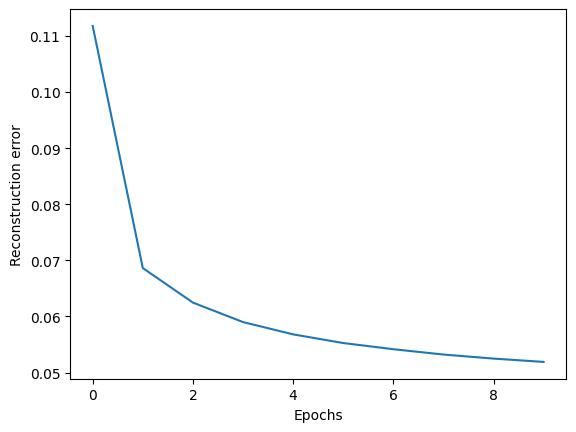

In [9]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

# Inference

## Evaluate

In [10]:
# set to evaluation mode
autoencoder.eval()
test_loss_avg, num_batches = 0, 0
all_latent_vecs = []
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        # image_batch_recon = autoencoder(image_batch)
        latent_vecs = autoencoder.encoder(image_batch)
        all_latent_vecs.append(latent_vecs)
        image_batch_recon = autoencoder.decoder(latent_vecs)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.052238


## Save stuff

In [11]:
# Save the pkl file
joblib.dump(all_latent_vecs, "all_latent_vecs.pkl")
torch.save(autoencoder, "autoencoder.ckpt")

## Visualize

Original images


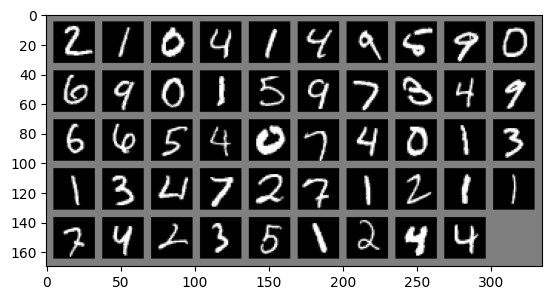

Autoencoder reconstruction:


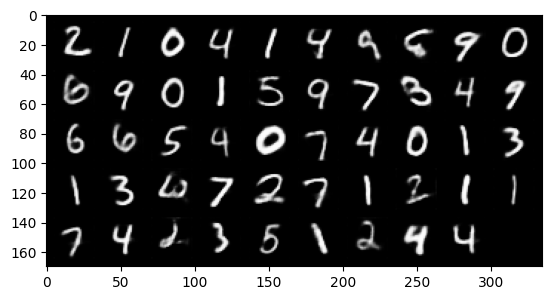

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))
# .next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

## Using AE for Image compression

Suppose we want to transfer the dataset to someone. What if instead of passing the whole dataset, we pass the latent vector and the model checkpoints. The recepient can reconstruct the image on their local machine with a reasonable (about 95 % accuracy in this case!).

To check how much of a compression this leads to, try comparing the size of the saved files and the actual dataset.

In [13]:
all_latent_vecs_loaded = joblib.load("all_latent_vecs.pkl")
# set to evaluation mode
autoencoder.eval()
test_loss_avg_from_loaded, num_batches = 0, 0
idx = -1
for image_batch, _ in test_dataloader:
    idx+= 1
    with torch.no_grad():
        image_batch = image_batch.to(device)
        # autoencoder reconstruction
        # image_batch_recon = autoencoder(image_batch)
        # latent_vecs = autoencoder.encoder(image_batch)
        latent_vecs_loaded = all_latent_vecs_loaded[idx]
        # all_latent_vecs.append(latent_vecs.cpu().numpy())
        image_batch_recon_from_loaded = autoencoder.decoder(latent_vecs_loaded)

        # reconstruction error
        loss_from_loaded = F.mse_loss(image_batch_recon_from_loaded, image_batch)

        test_loss_avg_from_loaded += loss_from_loaded.item()
        num_batches += 1

test_loss_avg_from_loaded /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.052238


## Interpolate in Latent Space

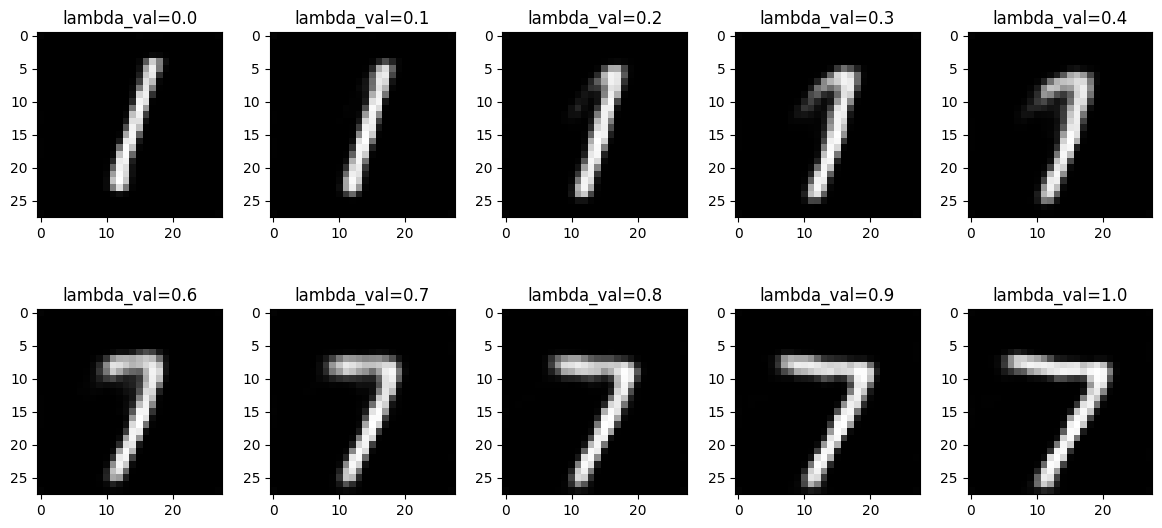

In [14]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

    return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show()

# 2. Train an Image Classification Network using the Above Pretrained Network

In [15]:
import time
import copy

In [16]:
dataloaders = {'train':train_dataloader, 'test':test_dataloader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [17]:
def train_classification_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Visualizing Data

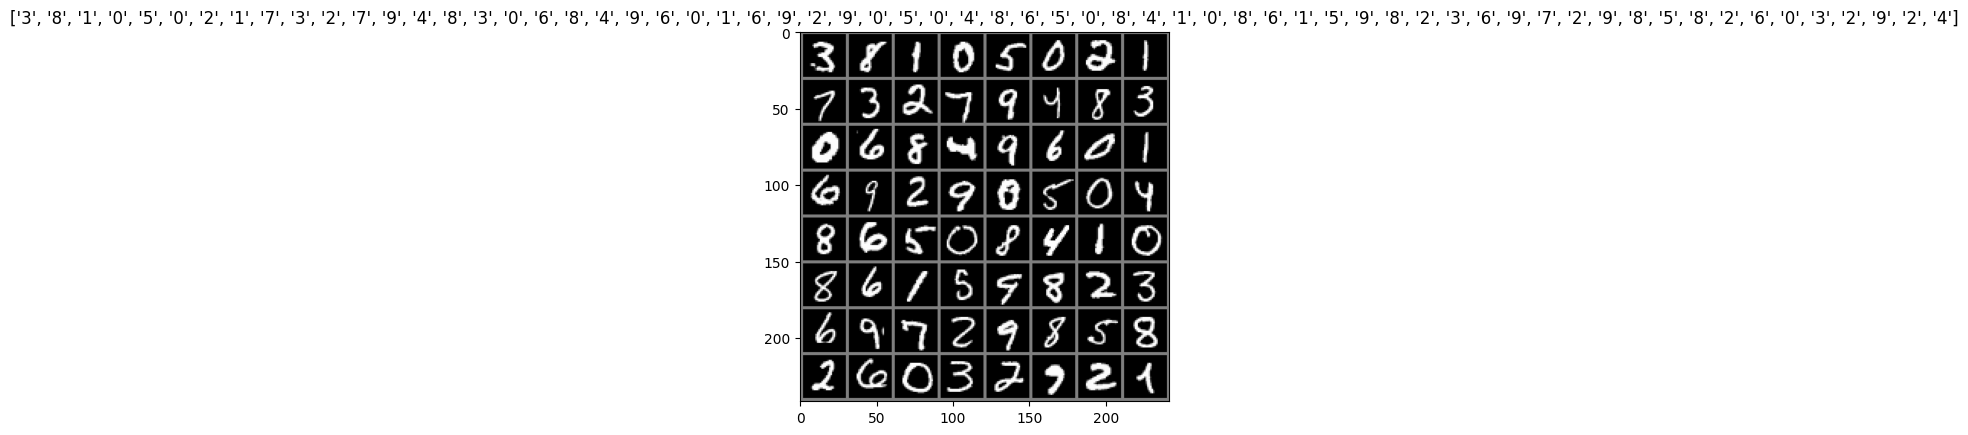

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
num_out_classes = 10
model_ft = autoencoder.encoder
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_out_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model_ft = train_classification_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4280 Acc: 0.8973
test Loss: 0.1469 Acc: 0.9598

Epoch 1/4
----------
train Loss: 0.1310 Acc: 0.9632
test Loss: 0.0954 Acc: 0.9730

Epoch 2/4
----------
train Loss: 0.0955 Acc: 0.9728
test Loss: 0.0743 Acc: 0.9784

Epoch 3/4
----------
train Loss: 0.0786 Acc: 0.9777
test Loss: 0.0668 Acc: 0.9791

Epoch 4/4
----------
train Loss: 0.0680 Acc: 0.9802
test Loss: 0.0567 Acc: 0.9826

Training complete in 1m 20s
Best test Acc: 0.982600


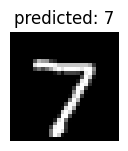

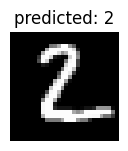

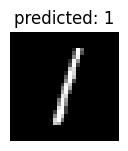

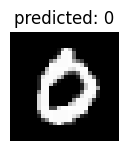

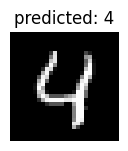

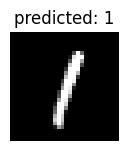

In [21]:
visualize_model(model_ft)

# 3. Train a Classification Network from Scratch

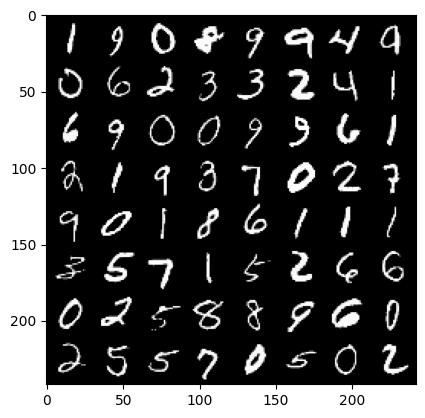

In [22]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [23]:
for images, labels in train_dataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [24]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.d1 = nn.Linear(7 * 7 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # flatten => 32 x (32*28*28)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [25]:
## test the model with 1 batch
model = MyModel()
for images, labels in train_dataloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


In [26]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [27]:
BATCH_SIZE = 128

def getValidationStats(criterion, valloader):
  val_loss, val_acc = 0.0, 0.0
  for j, (images, labels) in enumerate(valloader, 0):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      val_loss += criterion(outputs, labels).detach().item()
      val_acc += get_accuracy(outputs, labels, BATCH_SIZE)
  return val_loss/j, val_acc/j

In [28]:
history = []
model = model.to(device)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    val_running_loss = 0.0
    val_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    val_stats = getValidationStats(criterion, test_dataloader)
    val_running_loss += val_stats[0]
    val_acc += val_stats[1]

    model.eval()
    print('Epoch: %d | Loss: %.4f | Test loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f' \
          %(epoch, train_running_loss / i, val_running_loss, train_acc/i, val_acc))
    history.append([epoch, train_running_loss/i, val_running_loss, train_acc/i, val_acc])

Epoch: 0 | Loss: 1.5522 | Test loss: 1.4976 | Train Accuracy: 45.96 | Test Accuracy: 48.80
Epoch: 1 | Loss: 1.4897 | Test loss: 1.4909 | Train Accuracy: 48.76 | Test Accuracy: 49.11
Epoch: 2 | Loss: 1.4823 | Test loss: 1.4888 | Train Accuracy: 49.10 | Test Accuracy: 49.21
Epoch: 3 | Loss: 1.4779 | Test loss: 1.4851 | Train Accuracy: 49.29 | Test Accuracy: 49.41
Epoch: 4 | Loss: 1.4762 | Test loss: 1.4834 | Train Accuracy: 49.39 | Test Accuracy: 49.44


In [29]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_dataloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 49.44


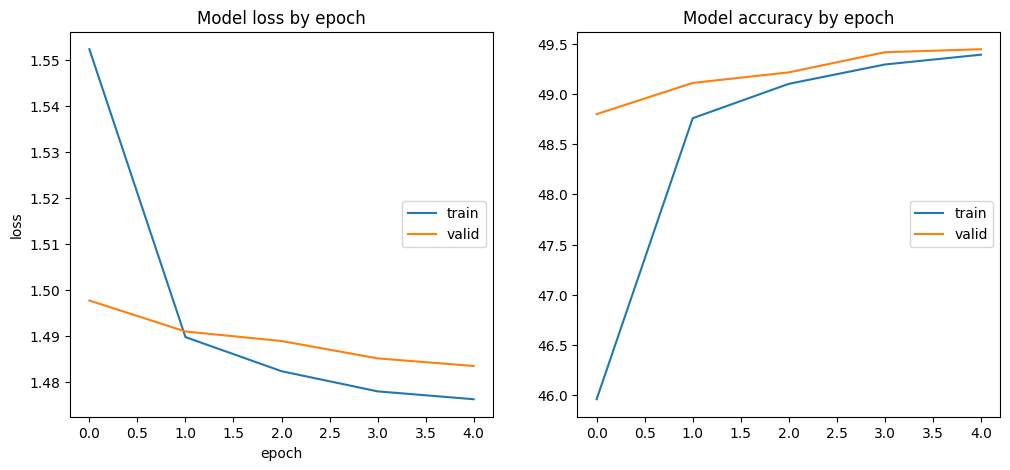

In [30]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))

history = np.array(history)
axis[0].plot(history[:, 1])
axis[0].plot(history[:, 2])
axis[1].plot(history[:, 3])
axis[1].plot(history[:, 4])

axis[0].set_title('Model loss by epoch')
axis[1].set_title('Model accuracy by epoch')
axis[0].set_ylabel('loss')
axis[0].set_xlabel('epoch')
axis[0].legend(['train', 'valid'], loc='right')
axis[1].legend(['train', 'valid'], loc='right')
plt.show()

# 4. Visualize Intermediate Layer Outputs

In [31]:
print(model)

MyModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (d1): Linear(in_features=1568, out_features=128, bias=True)
  (d2): Linear(in_features=128, out_features=10, bias=True)
)


In [32]:
layer1 = model.conv1
layer2 = model.conv2

In [33]:
layer1

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [34]:
num_ftrs

6272

In [35]:
def visualize_batch(batch):
  batch_size = batch.shape[0]
  num_channels = batch.shape[1]
  viz_shape = (batch.shape[2], batch.shape[3])
  fig, axs = plt.subplots(num_channels//8, 8)
  print(num_channels, num_channels//8)
  for img_num in range(batch_size):
    # print("Showing Image:", img_num)
    for channel_num in range(num_channels):
      # print(channel_num, num_ftrs, channel_num//8, channel_num%8)
      # print("Showing Channel:", channel_num)
      axs[channel_num//8, channel_num%8].imshow(batch[img_num, channel_num, :, :].cpu().numpy(), cmap='gray')
      axs[channel_num//8, channel_num%8].axis('off')
    plt.show()


16 2


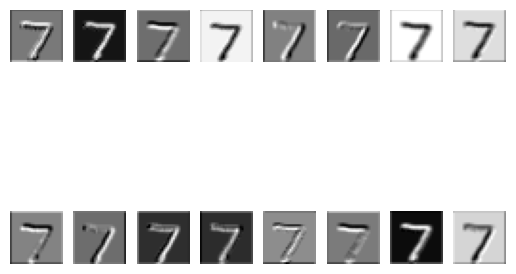

RuntimeError: ignored

In [36]:
# set to evaluation mode
autoencoder.eval()
test_loss_avg, num_batches = 0, 0
# all_latent_vecs = []

# fig = plt.figure(figsize=(8,16))
for image_batch, _ in test_dataloader:
    with torch.no_grad():
        image_batch = image_batch.to(device)
        out_l1 = layer1(image_batch)
        visualize_batch(out_l1)
        out_l1 = F.relu(image_batch)
        out_l1 = F.max_pool2d(out_l1,2,2)
        out_l2 = layer2(out_l1)
        print("Layer-2")
        visualize_batch(out_l2)
        print(out_l2.shape)
        break
        # out = model(image_batch)


        # # print(torch.max(out, axis=1)[1])
        # for idx in range(len(image_batch)):
        #     img_mpl = np.transpose(image_batch[idx, 0].cpu().numpy())

        #     print("Pred:",torch.max(out, axis=1)[1][idx])
        #     plt.imshow(img_mpl)
        #     plt.show()
        #     # break
        # break

#         # autoencoder reconstruction
#         # image_batch_recon = autoencoder(image_batch)
#         latent_vecs = autoencoder.encoder(image_batch)
#         all_latent_vecs.append(latent_vecs)
#         image_batch_recon = autoencoder.decoder(latent_vecs)

#         # reconstruction error
#         loss = F.mse_loss(image_batch_recon, image_batch)

#         test_loss_avg += loss.item()
#         num_batches += 1

# test_loss_avg /= num_batches
# print('average reconstruction error: %f' % (test_loss_avg))

In [ ]:
print(model_ft)

In [ ]:
def conv_model_weights(model):
  model_weights = []
  conv_layers = []

  model_children = list(model_ft.children())

  count = 0

  for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
      count+= 1
      model_weights.append(model_children[i].weight)
      conv_layers.append(model_children[i])

  print(f"Total convolution layers: {count}")
  print("conv_layers")

  return model_weights, conv_layers

model_weights, conv_layers = conv_model_weights(model)

In [ ]:
outputs = []
names = []
for image_batch,_ in test_dataloader:
  image = image_batch[12]
  image = image.to(device)
  for layer in conv_layers[0:]:
      image = layer(image)
      outputs.append(image)
      names.append(str(layer))
      image = F.relu(image)
  print(len(outputs))
  #print feature_maps
  for feature_map in outputs:
      print(feature_map.shape)
  break


In [ ]:
outputs = []
names = []
for image_batch,_ in test_dataloader:
  image = image_batch[12]
  image = image.to(device)
  for layer in conv_layers[0:]:
      image = layer(image)
      outputs.append(image)
      names.append(str(layer))
      image = F.relu(image)
      image = F.max_pool2d(image,2,2)
  print(len(outputs))
  #print feature_maps
  for feature_map in outputs:
      print(feature_map.shape)
  break

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)


fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

# Reference Link

- https://towardsdatascience.com/reveling-what-neural-networks-see-and-learn-pytorchrevelio-a218ef5fc61f
- https://github.com/farhad-dalirani/PytorchRevelio